In [1]:
import torch
import numpy as np
from torch import nn
from tqdm.auto import tqdm
from torchvision import datasets
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!
from torchsummary import summary
import torch.nn.functional as F

# library to get dataloader
from dataloaders import get_pkmn_dataloader

# library to get loss functions
from loss_functions import get_generator_loss_func,get_disc_loss_func,gradient_penalty,get_gradient

# generators and discriminators
from DCGeneratorCustom import DCGeneratorCustom
from DCDiscriminatorCustom import DCDiscriminatorCustom
from DCGeneratorStandard import DCGeneratorStandard
from DCDiscriminatorStandard import DCDiscriminatorStandard
from DCDiscriminatorStandardDropout import DCDiscriminatorStandardDropout

from DCGeneratorConditional import DCGeneratorConditional
from DCDiscriminatorConditional import DCDiscriminatorConditional

# util methods
from utils import get_noise

# constants
from pkmn_constants import PKMN_TYPES,CLASS_IDX_2_PKMN_TYPE,NUM_PKMN_TYPES

# whether to use CPU/GPU (pass this along everywhere)
device_str = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device_str)

print("Using device: {}".format(device_str))

Using device: cpu


In [2]:
print(torch.__version__)

# if apply_denormalization is true, then we re-scale the images back 
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), denorm_transform = None, use_uniform_transform = False):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    
    # We don't specifically need this since we are doing the denormalization ourself
    
    if denorm_transform is not None:
      assert use_uniform_transform == False
      image_tensor = denorm_transform(image_tensor)
    if use_uniform_transform:
      # cannot use both uniform and denorm transform together
      assert denorm_transform == None
      image_tensor = (image_tensor + 1) / 2 # scale from [-1, 1] to [0, 1] space
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

def save_model(model, output_filename):
  torch.save(model.state_dict(), output_filename)

1.10.2


In [3]:
# playing around with the generator the output shape. These layers give an output shape of 64
show_summary = True
test_batch_size = 4

test_gen = DCGeneratorConditional(hidden_dim = 40, use_class_embed = False)
out = test_gen(torch.ones(test_batch_size,16), torch.ones(test_batch_size).long())

assert out.shape[0] == test_batch_size
assert out.shape[1] == 3 # output should have 3 channels (r,g,b)
assert out.shape[2] == test_gen.output_dim # output should have the proper [width, height]

# shape does not include the batch size
# just force the cpu to display the graph
if show_summary:
  summary(test_gen, [(1, 16), (1,1)], device = 'cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 320, 4, 4]         174,400
       BatchNorm2d-2            [-1, 320, 4, 4]             640
              ReLU-3            [-1, 320, 4, 4]               0
   ConvTranspose2d-4            [-1, 160, 8, 8]         819,360
       BatchNorm2d-5            [-1, 160, 8, 8]             320
              ReLU-6            [-1, 160, 8, 8]               0
   ConvTranspose2d-7           [-1, 80, 16, 16]         204,880
       BatchNorm2d-8           [-1, 80, 16, 16]             160
              ReLU-9           [-1, 80, 16, 16]               0
  ConvTranspose2d-10           [-1, 40, 32, 32]          51,240
      BatchNorm2d-11           [-1, 40, 32, 32]              80
             ReLU-12           [-1, 40, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           1,923
             Tanh-14            [-1, 3,

In [4]:
# playing around with the discriminator and the output shape
show_summary = True
test_batch_size = 7

test_disc = DCDiscriminatorConditional(hidden_dim = 30, early_dropout = 0.3, mid_dropout = 0.3, late_dropout = 0.35)
out = test_disc(torch.ones(test_batch_size, 3, 64, 64), torch.ones(test_batch_size).long())

print("Shape of discriminator output is: {}".format(out.shape))

# output shape is (1,64) ---> why does it have 64 dimensions ? Don't we want a single prediction between 0 and 1 ?
assert out.shape[0] == test_batch_size
assert out.shape[1] == 1 # should only have one probability for the output

if show_summary:
  summary(test_disc, [(3, 64, 64), (1,1)], device = 'cpu')

Shape of discriminator output is: torch.Size([7, 1])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1                   [-1, 16]             288
            Conv2d-2           [-1, 30, 32, 32]           1,950
       BatchNorm2d-3           [-1, 30, 32, 32]              60
         LeakyReLU-4           [-1, 30, 32, 32]               0
         Dropout2d-5           [-1, 30, 32, 32]               0
            Conv2d-6           [-1, 60, 16, 16]          28,860
       BatchNorm2d-7           [-1, 60, 16, 16]             120
         LeakyReLU-8           [-1, 60, 16, 16]               0
            Conv2d-9            [-1, 120, 8, 8]         115,320
      BatchNorm2d-10            [-1, 120, 8, 8]             240
        LeakyReLU-11            [-1, 120, 8, 8]               0
        Dropout2d-12            [-1, 120, 8, 8]               0
           Conv2d-13            [-1, 240, 4, 4]   

/Users/moose_abdool/miniconda3/envs/cs236g_py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


TypeError: can't multiply sequence by non-int of type 'tuple'

In [5]:
# ======= Define the basic hyper-parameters =====


# training epochs
n_epochs = 1

# dimension of noise vector
z_dim = 32
# hidden dimensions
hidden_dim_gen = 40
hidden_dim_disc = 55
disc_class_embed_size = 16
batch_size = 32
# how often to display images and debug info. Basically, the numerator is how many images you want to
# process before showing some debug info
display_step = int((4000 / batch_size))
periodic_saving = False
# after how many epochs do you save the model?
epoch_save_step = 1
save_prefix = "experiment_9/test_wgan_stuff"
imgs_to_display = 10

print("Planning to display images every {} steps".format(display_step))

# other sources say 0.00275 works better...but the DCGAn paper used 0.0002 (ie. about 10-4 instead of 10-3)
gen_lr = 0.0002 # 0.0002 works for both, but takes at least 10-15 epochs before anything interesting happens?
disc_lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
disc_repeats = 1
gen_repeats = 1

# loss functions
use_wgan_loss = False
if use_wgan_loss:
  gen_loss_func = get_generator_loss_func("wgan_gen_loss")
  disc_loss_func = get_disc_loss_func("wgan_disc_loss")
  c_lambda = 10
else:
  gen_loss_func = get_generator_loss_func("basic_gen_loss")
  disc_loss_func = get_disc_loss_func("noisy_disc_loss")

assert imgs_to_display <= batch_size

Planning to display images every 125 steps


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


  0%|          | 0/887 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[Dataloader Stats] Final mean per channel is: tensor([0.8854, 0.8733, 0.8612]), final std per channel is: tensor([0.2128, 0.2266, 0.2403])


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


length of dataset (number of steps) is: 222, total size is: 7104


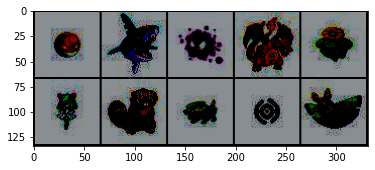

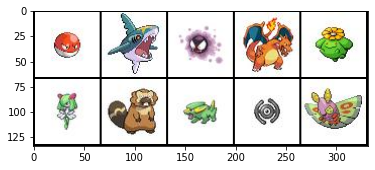

In [6]:
# Create the dataloader, based on the appropriate batch size. 

show_preview = True
dataloader_name = "conditional_64_dim_no_shiny_with_flip_custom_norm"
pkmn_dataloader, denorm_transform = get_pkmn_dataloader(dataloader_name, batch_size)
test_size = 10

# show a batch before and after denorm
test_data_iter = iter(pkmn_dataloader)
test_images, test_labels = next(test_data_iter)

print("length of dataset (number of steps) is: {}, total size is: {}".format(len(pkmn_dataloader), len(pkmn_dataloader)*batch_size))

if show_preview:
  show_tensor_images(test_images[0:test_size], num_images = test_size, size = (3,64,64), denorm_transform = None)
  show_tensor_images(test_images[0:test_size], num_images = test_size, size = (3,64,64), denorm_transform = denorm_transform)


In [7]:
# Create the generator/discriminator and use them
# layer initialization for Generator and Discriminator (for Conv2d and ConvTranpose2d)

gen = DCGeneratorConditional(z_dim = z_dim, hidden_dim = hidden_dim_gen, use_class_embed = False).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=gen_lr, betas=(beta_1, beta_2))
disc = DCDiscriminatorConditional(hidden_dim = hidden_dim_disc, class_embed_size = disc_class_embed_size).to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=disc_lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


  0%|          | 0/222 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Step 125: Epoch: 0: Generator loss: -0.7983990259170533, discriminator loss: 4.012390069007873 mean disc pred on real images: 0.34451913833618164, fake images: 0.8042312860488892


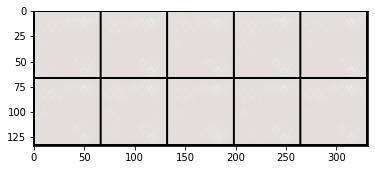

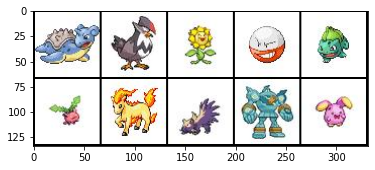

Pokemon types we are trying to generate are: ['Ice', 'Normal', 'Grass', 'Electric', 'Poison'] 
    	 	 	 	 	 ['Flying', 'Fire', 'Poison', 'Ghost', 'Normal']


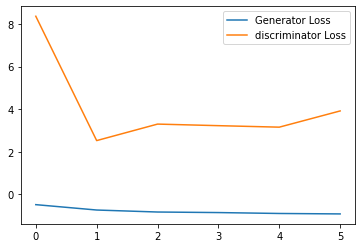

In [8]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

cur_step = 0
generator_losses = []
discriminator_losses = []
discriminator_fake_preds = [] # median value of P(real) the discriminator predicts on the fake images (per batch)
discriminator_real_preds = [] # median value of P(real) the discriminator predicts on the real images (per batch)


for epoch in range(n_epochs):
    # Dataloader returns the (real_images, labels)
    for real, true_labels in tqdm(pkmn_dataloader):
        cur_batch_size = len(real)
        real = real.to(device)
        true_labels = true_labels.to(device)
        
        mean_iteration_discriminator_loss = 0
        for _ in range(disc_repeats):
            ### Update discriminator ###
            disc_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise, true_labels)
                        
            disc_fake_pred = disc(fake.detach(), true_labels)
            disc_real_pred = disc(real, true_labels)

            
            if use_wgan_loss:
              epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
              gradient = get_gradient(disc, real, true_labels, fake.detach(), epsilon)
              gp = gradient_penalty(gradient)
              # how should we track these two relative losses ?
              disc_loss = disc_loss_func(disc_fake_pred, disc_real_pred, gp, c_lambda)              

            else:
              # compute discriminator loss normally
              disc_loss = disc_loss_func(disc_fake_pred, disc_real_pred, device)
            
            # Keep track of the average discriminator loss in this batch
            mean_iteration_discriminator_loss += disc_loss.item() / disc_repeats
            
            # Update gradients
            # when using WGAN, we have retain_graph = True, but it probably takes longer
            disc_loss.backward(retain_graph=use_wgan_loss)
            
            # Update optimizer
            disc_opt.step()
            
        discriminator_losses += [mean_iteration_discriminator_loss]
        # notice this only takes the last one from the iteration
        discriminator_fake_preds += [torch.mean(disc_fake_pred)]
        discriminator_real_preds += [torch.mean(disc_real_pred)]

        ### Update generator ###
        mean_iteration_gen_loss = 0
        for _ in range(gen_repeats):
          gen_opt.zero_grad()
          fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
          fake_2 = gen(fake_noise_2, true_labels)
          disc_fake_pred = disc(fake_2, true_labels)

          # compute gen loss
          gen_loss = gen_loss_func(disc_fake_pred, device)
          
          mean_iteration_gen_loss += gen_loss.item() / gen_repeats
          
          gen_loss.backward()

          # Update the weights
          gen_opt.step()

        # Keep track of the average generator loss
        generator_losses += [mean_iteration_gen_loss]
        
        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            disc_mean = sum(discriminator_losses[-display_step:]) / display_step
            # maybe print out the last values here ? To see how stable it is overtime ? These all seem to be very close to 0.5 / 1
            disc_prediction_real = sum(discriminator_real_preds[-display_step:]) / display_step
            disc_prediction_fake = sum(discriminator_fake_preds[-display_step:]) / display_step
            print(f"Step {cur_step}: Epoch: {epoch}: Generator loss: {gen_mean}, discriminator loss: {disc_mean} mean disc pred on real images: {disc_prediction_real}, fake images: {disc_prediction_fake}")
            show_tensor_images(fake[0:imgs_to_display], imgs_to_display, size = (3,64,64), denorm_transform = denorm_transform)
            show_tensor_images(real[0:imgs_to_display], imgs_to_display, size = (3,64,64), denorm_transform = denorm_transform)
            
            ground_truth_types = [CLASS_IDX_2_PKMN_TYPE[class_idx] for class_idx in true_labels[0:imgs_to_display].cpu().numpy()]
            print("Pokemon types we are trying to generate are: {} \n    \t \t \t \t \t {}".format(ground_truth_types[0:5], ground_truth_types[5:]))
            
            step_bins = 20
            
            # todo: add proper labels to this plot
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="discriminator Loss"
            )
            plt.legend()
            plt.show()
        
        # increase the current step (ie. one batch)
        cur_step += 1
        
    if periodic_saving and epoch % epoch_save_step == 0:
      outfile_name = "{}_{}.pt".format(save_prefix, cur_step)
      print("===== Saving intermediate model with name {} ! ====".format(outfile_name))
      save_model(gen, outfile_name)

In [ ]:
# Save the final model

out_file = "second_gan_with_standard_dcgan_arch_after_149epochs.pt"
  
save_model(gen, out_file)

In [ ]:
# Load model for inference and generate some random classes

gen.load_state_dict(torch.load("{}".format(out_file)))

# Performing inference - actually, maybe I ran some other cell after this so it's not really well defined
num_samples = 10

sample_vector = get_noise(num_samples, z_dim, device)
random_classes = torch.randint(low = 0, high = NUM_PKMN_TYPES, size = (num_samples,)).to(device)

fake_images = gen(sample_vector, random_classes)

output_size = gen.output_dim
# + 0.9
show_tensor_images(fake_images, num_images=num_samples, size=(1,256, 256), use_uniform_transform = True, denorm_transform = None)


pkmn_classes = [CLASS_IDX_2_PKMN_TYPE[class_idx] for class_idx in random_classes.cpu().numpy()]
print("Pokemon types we are trying to generate are: {} \n    \t \t \t \t \t {}".format(pkmn_classes[0:5], pkmn_classes[5:]))

In [ ]:
# Generate samples of a specific type from the model
target_type = "Fire"
class_idx = PKMN_TYPES.index(target_type)

class_tiled = torch.from_numpy(np.array([class_idx] * num_samples))

sample_vector = get_noise(num_samples, z_dim, device)
classes = class_tiled.to(device)

fake_images = gen(sample_vector, classes)

output_size = gen.output_dim
# + 0.9
show_tensor_images(fake_images, num_images=num_samples, size=(1,256, 256), use_uniform_transform = True, denorm_transform = None)


pkmn_classes = [CLASS_IDX_2_PKMN_TYPE[class_idx] for class_idx in classes.cpu().numpy()]
print("Pokemon types we are trying to generate are: {} \n    \t \t \t \t \t {}".format(pkmn_classes[0:5], pkmn_classes[5:]))
